# Exploración de Datos - Dataset de Sensibilidad de Películas

Este notebook realiza una exploración exhaustiva de los datos tanto en su forma original (raw) como después del procesamiento. Analizaremos:

1. **Datos RAW**: ratings.csv, movies.csv, ddd_dict.pkl
2. **Datos PROCESADOS**: peliculas_sensibilidad_goldAnt.csv
3. **Análisis comparativo** entre datasets

El objetivo es entender la calidad, distribución y patrones en los datos para validar el pipeline de procesamiento.

## Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import warnings
import re

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(" Librerías importadas correctamente")

 Librerías importadas correctamente


## Configuración de Rutas y Verificación de Archivos

In [2]:
# Definir rutas de los datasets
base_path = Path("..")
raw_data_path = base_path / "data" / "raw" / "train" / "ml"
processed_data_path = base_path / "data" / "processed" / "ml"

# Verificar que las rutas existan
print(" Verificando rutas:")
print(f"  Datos RAW: {raw_data_path.exists()} - {raw_data_path}")
print(f"  Datos PROCESADOS: {processed_data_path.exists()} - {processed_data_path}")

# Listar archivos disponibles
if raw_data_path.exists():
    print(f"\n Archivos RAW disponibles:")
    for file in raw_data_path.iterdir():
        if file.is_file():
            size_mb = file.stat().st_size / (1024*1024)
            print(f"  • {file.name}: {size_mb:.1f} MB")

if processed_data_path.exists():
    print(f"\n Archivos PROCESADOS disponibles:")
    for file in processed_data_path.iterdir():
        if file.is_file():
            size_mb = file.stat().st_size / (1024*1024)
            print(f"  • {file.name}: {size_mb:.1f} MB")

 Verificando rutas:
  Datos RAW: True - ..\data\raw\train\ml
  Datos PROCESADOS: True - ..\data\processed\ml

 Archivos RAW disponibles:
  • ddd_dict.pkl: 131.2 MB
  • links.csv: 1.3 MB
  • movies.csv: 2.9 MB
  • ratings.csv: 646.8 MB

 Archivos PROCESADOS disponibles:
  • peliculas_sensibilidad_goldAnt.csv: 38.6 MB


# 1. Análisis de Datos RAW

Exploramos los datos originales antes del procesamiento.

## 1.1 Análisis de Ratings (ratings.csv)

 Cargando muestra de ratings (500K registros)...
 Muestra cargada: 500,000 registros

 Estadísticas de ratings:
count    500000.000000
mean          3.549066
std           1.055825
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

 Usuarios únicos: 3,445
 Películas únicas: 17,466


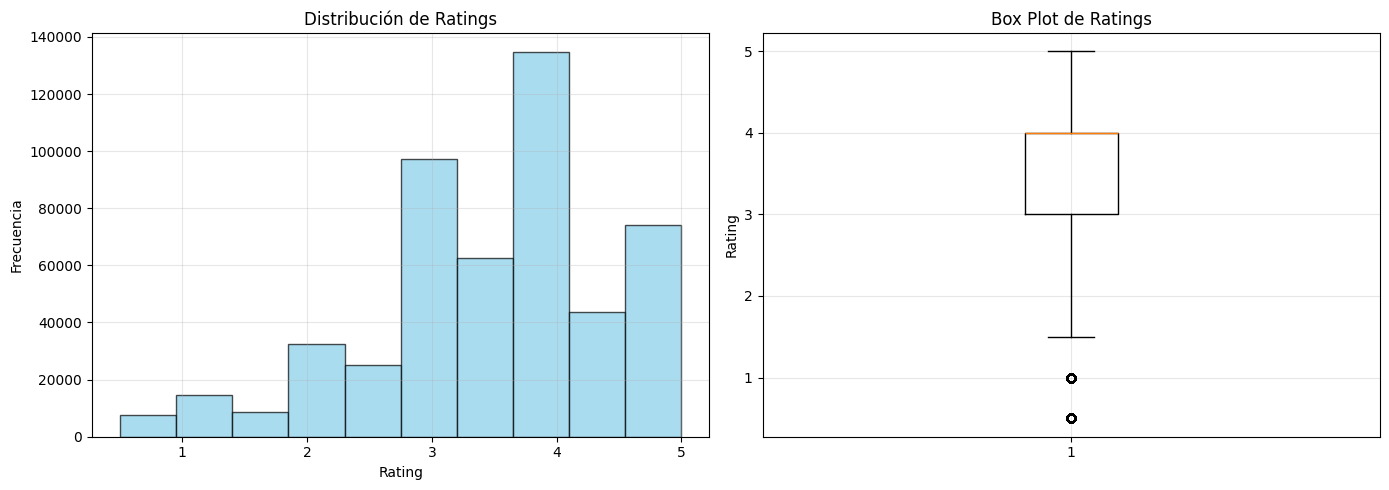


 Visualización completada


In [3]:
# Cargar muestra de ratings
print(" Cargando muestra de ratings (500K registros)...")
ratings_sample = pd.read_csv(raw_data_path / "ratings.csv", nrows=500000)

print(f" Muestra cargada: {len(ratings_sample):,} registros")
#print(f" Período: {ratings_sample['timestamp'].min()} - {ratings_sample['timestamp'].max()}")
print(f"\n Estadísticas de ratings:")
print(ratings_sample['rating'].describe())

print(f"\n Usuarios únicos: {ratings_sample['userId'].nunique():,}")
print(f" Películas únicas: {ratings_sample['movieId'].nunique():,}")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
ax1.hist(ratings_sample['rating'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Ratings')
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(ratings_sample['rating'])
ax2.set_ylabel('Rating')
ax2.set_title('Box Plot de Ratings')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Visualización completada")

In [4]:
ratings_sample.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
ratings_sample.describe()

,userId,movieId,rating,timestamp
count,500000.000000,500000.000000,500000.000000,5.000000e+05
mean,1745.358206,20637.567424,3.549066,1.206606e+09
std,976.020643,38556.390766,1.055825,2.295781e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,897.000000,1131.000000,3.000000,9.956829e+08
50%,1751.000000,2792.000000,4.000000,1.176779e+09
75%,2580.000000,7934.000000,4.000000,1.444217e+09
max,3445.000000,208939.000000,5.000000,1.574254e+09


In [6]:
ratings_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     500000 non-null  int64  
 1   movieId    500000 non-null  int64  
 2   rating     500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 15.3 MB


## 1.2 Análisis de Películas (movies.csv)

In [7]:
# Cargar datos de películas
print(" Cargando datos de películas...")
movies_df = pd.read_csv(raw_data_path / "movies.csv")

print(f" {len(movies_df):,} películas cargadas")
print(f"\n Primeras películas:")
display(movies_df.head())

# Extraer géneros únicos
all_genres = []
for genres_str in movies_df['genres'].dropna():
    if genres_str != "(no genres listed)":
        all_genres.extend(genres_str.split('|'))

unique_genres = list(set(all_genres))
print(f"\n Géneros únicos: {len(unique_genres)}")
print(f"Géneros: {sorted(unique_genres)}")

# Extraer años
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

movies_df['year'] = movies_df['title'].apply(extract_year)
print(f"\n Rango temporal: {movies_df['year'].min():.0f} - {movies_df['year'].max():.0f}")

 Cargando datos de películas...
 62,423 películas cargadas

 Primeras películas:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



 Géneros únicos: 19
Géneros: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

 Rango temporal: 1874 - 2019


In [8]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


In [9]:
movies_df.describe()

,movieId,year
count,62423.000000,62013.000000
mean,122220.387646,1992.044700
std,63264.744844,25.364884
min,1.000000,1874.000000
25%,82146.500000,1976.000000
50%,138022.000000,2002.000000
75%,173222.000000,2012.000000
max,209171.000000,2019.000000


In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   title    62423 non-null  object 
 2   genres   62423 non-null  object 
 3   year     62013 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.9+ MB


In [11]:
import pandas as pd

# Separar los géneros (cada película puede tener varios separados por '|')
all_genres = []
for genres_str in movies_df['genres'].dropna():
    if genres_str != "(no genres listed)":
        all_genres.extend(genres_str.split('|'))

# Contar la frecuencia de cada género
genre_counts = pd.Series(all_genres).value_counts()

# Mostrar los resultados ordenados
print("🎬 Conteo de películas por género:")
print(genre_counts)

# Si deseas convertirlo en DataFrame para exportar o visualizar
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Género', 'Número de películas']

# Mostrar los 10 géneros más frecuentes
print("\nTop 10 géneros más frecuentes:")
print(genre_counts_df.head(10))


🎬 Conteo de películas por género:
Drama          25606
Comedy         16870
Thriller        8654
Romance         7719
Action          7348
Horror          5989
Documentary     5605
Crime           5319
Adventure       4145
Sci-Fi          3595
Children        2935
Animation       2929
Mystery         2925
Fantasy         2731
War             1874
Western         1399
Musical         1054
Film-Noir        353
IMAX             195
Name: count, dtype: int64

Top 10 géneros más frecuentes:
        Género  Número de películas
0        Drama                25606
1       Comedy                16870
2     Thriller                 8654
3      Romance                 7719
4       Action                 7348
5       Horror                 5989
6  Documentary                 5605
7        Crime                 5319
8    Adventure                 4145
9       Sci-Fi                 3595


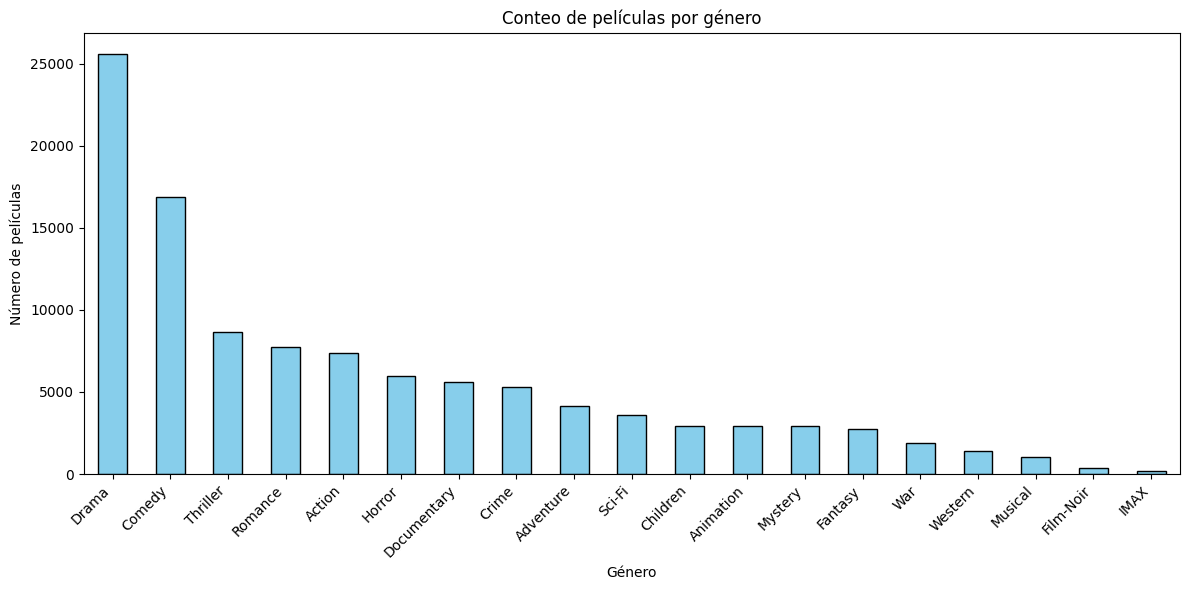

In [9]:
import matplotlib.pyplot as plt

genre_counts.head(19).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Conteo de películas por género")
plt.xlabel("Género")
plt.ylabel("Número de películas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 2. Análisis del Dataset Final Procesado

Analizamos el dataset resultante con scores de sensibilidad.

In [12]:
# Cargar dataset final
print(" Cargando dataset final procesado...")
final_df = pd.read_csv(processed_data_path / "peliculas_sensibilidad_goldAnt.csv")

print(f" Dataset cargado: {final_df.shape[0]:,} películas × {final_df.shape[1]} columnas")
print(f" Tamaño en memoria: {final_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Identificar columnas
score_cols = [col for col in final_df.columns if col.endswith('_score')]
print(f"\n Scores de sensibilidad encontrados:")
for col in score_cols:
    non_zero = (final_df[col] > 0).sum()
    pct = (non_zero / len(final_df)) * 100
    print(f"  • {col}: {non_zero:,} películas ({pct:.1f}%)")

print(f"\n Primeras filas:")
display(final_df[['title', 'genres', 'n_ratings', 'av_rating', 'aptitud_familiar'] + score_cols].head(10))

 Cargando dataset final procesado...
 Dataset cargado: 32,604 películas × 572 columnas
 Tamaño en memoria: 156.4 MB

 Scores de sensibilidad encontrados:
  • violencia_score: 8,666 películas (26.6%)
  • drogas_score: 6,517 películas (20.0%)
  • suicidio_score: 2,835 películas (8.7%)
  • lenguaje_fuerte_score: 3,841 películas (11.8%)
  • sexualidad_score: 6,906 películas (21.2%)

 Primeras filas:


,title,genres,n_ratings,av_rating,aptitud_familiar,violencia_score,drogas_score,suicidio_score,lenguaje_fuerte_score,sexualidad_score
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309,3.893708,70.0,0.143,0.000,0.0,0.000,0.000
1,Jumanji (1995),Adventure|Children|Fantasy,24228,3.251527,70.0,0.214,0.000,0.0,0.167,0.000
2,Grumpier Old Men (1995),Comedy|Romance,11804,3.142028,100.0,0.000,0.000,0.0,0.000,0.000
3,Waiting to Exhale (1995),Comedy|Drama|Romance,2523,2.853547,55.0,0.000,0.750,0.0,1.000,0.333
4,Father of the Bride Part II (1995),Comedy,11714,3.058434,90.0,0.000,0.000,0.0,0.000,0.500
5,Heat (1995),Action|Crime|Thriller,24588,3.854909,0.0,0.571,0.600,0.5,0.250,0.417
6,Sabrina (1995),Comedy|Romance,12132,3.363666,100.0,0.000,0.125,0.0,0.167,0.167
7,Tom and Huck (1995),Adventure|Children,1344,3.114583,100.0,0.000,0.000,0.0,0.000,0.000
8,GoldenEye (1995),Action|Adventure|Thriller,28265,3.421458,60.0,0.286,0.000,0.0,0.000,0.500
9,"American President, The (1995)",Comedy|Drama|Romance,17042,3.657171,100.0,0.000,0.000,0.0,0.000,0.000


In [13]:
final_df.head()

,work_id,Clear Yes: Does a horse die,Clear No: Does a horse die,Unclear: Does a horse die,No Votes: Does a horse die,Clear Yes: Does the dog die,Clear No: Does the dog die,Unclear: Does the dog die,No Votes: Does the dog die,Clear Yes: Are animals abused,Clear No: Are animals abused,Unclear: Are animals abused,No Votes: Are animals abused,Clear Yes: Does a pet die,Clear No: Does a pet die,Unclear: Does a pet die,No Votes: Does a pet die,Clear Yes: Is there dog fighting,Clear No: Is there dog fighting,Unclear: Is there dog fighting,No Votes: Is there dog fighting,Clear Yes: Are there bugs,Clear No: Are there bugs,Unclear: Are there bugs,No Votes: Are there bugs,Clear Yes: Is there a dead animal,Clear No: Is there a dead animal,Unclear: Is there a dead animal,No Votes: Is there a dead animal,Clear Yes: Does a dragon die,Clear No: Does a dragon die,Unclear: Does a dragon die,No Votes: Does a dragon die,Clear Yes: Does a cat die,Clear No: Does a cat die,Unclear: Does a cat die,No Votes: Does a cat die,Clear Yes: Does an animal die,Clear No: Does an animal die,Unclear: Does an animal die,No Votes: Does an animal die,Clear Yes: Are there snakes,Clear No: Are there snakes,Unclear: Are there snakes,No Votes: Are there snakes,Clear Yes: Are there spiders,Clear No: Are there spiders,Unclear: Are there spiders,No Votes: Are there spiders,Clear Yes: Is a child abandoned by a parent,Clear No: Is a child abandoned by a parent,Unclear: Is a child abandoned by a parent,No Votes: Is a child abandoned by a parent,Clear Yes: Is someone gaslighted,Clear No: Is someone gaslighted,Unclear: Is someone gaslighted,No Votes: Is someone gaslighted,Clear Yes: Does the abused become the abuser,Clear No: Does the abused become the abuser,Unclear: Does the abused become the abuser,No Votes: Does the abused become the abuser,Clear Yes: Is someone stalked,Clear No: Is someone stalked,Unclear: Is someone stalked,No Votes: Is someone stalked,Clear Yes: Is a child abused,Clear No: Is a child abused,Unclear: Is a child abused,No Votes: Is a child abused,Clear Yes: Is there domestic violence,Clear No: Is there domestic violence,Unclear: Is there domestic violence,No Votes: Is there domestic violence,Clear Yes: Is there addiction,Clear No: Is there addiction,Unclear: Is there addiction,No Votes: Is there addiction,Clear Yes: Does someone use drugs,Clear No: Does someone use drugs,Unclear: Does someone use drugs,No Votes: Does someone use drugs,Clear Yes: Does someone abuse alcohol,Clear No: Does someone abuse alcohol,Unclear: Does someone abuse alcohol,No Votes: Does someone abuse alcohol,Clear Yes: Is someone drugged,Clear No: Is someone drugged,Unclear: Is someone drugged,No Votes: Is someone drugged,Clear Yes: Is someone restrained,Clear No: Is someone restrained,Unclear: Is someone restrained,No Votes: Is someone restrained,Clear Yes: Is someone sexually assaulted,Clear No: Is someone sexually assaulted,Unclear: Is someone sexually assaulted,No Votes: Is someone sexually assaulted,Clear Yes: Is someone raped onscreen,Clear No: Is someone raped onscreen,Unclear: Is someone raped onscreen,No Votes: Is someone raped onscreen,Clear Yes: Is there cannibalism,Clear No: Is there cannibalism,Unclear: Is there cannibalism,No Votes: Is there cannibalism,Clear Yes: Is there body horror,Clear No: Is there body horror,Unclear: Is there body horror,No Votes: Is there body horror,Clear Yes: Is there amputation,Clear No: Is there amputation,Unclear: Is there amputation,No Votes: Is there amputation,Clear Yes: Is there finger/toe mutilation,Clear No: Is there finger/toe mutilation,Unclear: Is there finger/toe mutilation,No Votes: Is there finger/toe mutilation,Clear Yes: Is someone crushed to death,Clear No: Is someone crushed to death,Unclear: Is someone crushed to death,No Votes: Is someone crushed to death,Clear Yes: Is there Achilles Tendon injury,Clear No: Is there Achilles Tendon injury,Unclear: Is there Achilles Tendon injury,No Votes: Is there Achilles Tendon injury,Cle

In [14]:
final_df[['title', 'genres', 'n_ratings', 'av_rating', 'aptitud_familiar'] + score_cols].describe()

,n_ratings,av_rating,aptitud_familiar,violencia_score,drogas_score,suicidio_score,lenguaje_fuerte_score,sexualidad_score
count,32604.000000,32604.000000,32604.000000,32604.000000,32604.000000,32604.000000,32604.000000,32604.000000
mean,701.376273,3.109988,83.661974,0.119040,0.096590,0.057207,0.054596,0.109926
std,3151.768301,0.574809,26.961642,0.239221,0.233071,0.204322,0.175742,0.247137
min,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.787434,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,3.181993,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,142.250000,3.503441,100.000000,0.143000,0.000000,0.000000,0.000000,0.000000
max,81491.000000,5.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
final_df[['title', 'genres', 'n_ratings', 'av_rating', 'aptitud_familiar'] + score_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32604 entries, 0 to 32603
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  32604 non-null  object 
 1   genres                 32604 non-null  object 
 2   n_ratings              32604 non-null  int64  
 3   av_rating              32604 non-null  float64
 4   aptitud_familiar       32604 non-null  float64
 5   violencia_score        32604 non-null  float64
 6   drogas_score           32604 non-null  float64
 7   suicidio_score         32604 non-null  float64
 8   lenguaje_fuerte_score  32604 non-null  float64
 9   sexualidad_score       32604 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


## 2.1 Visualización de Scores de Sensibilidad

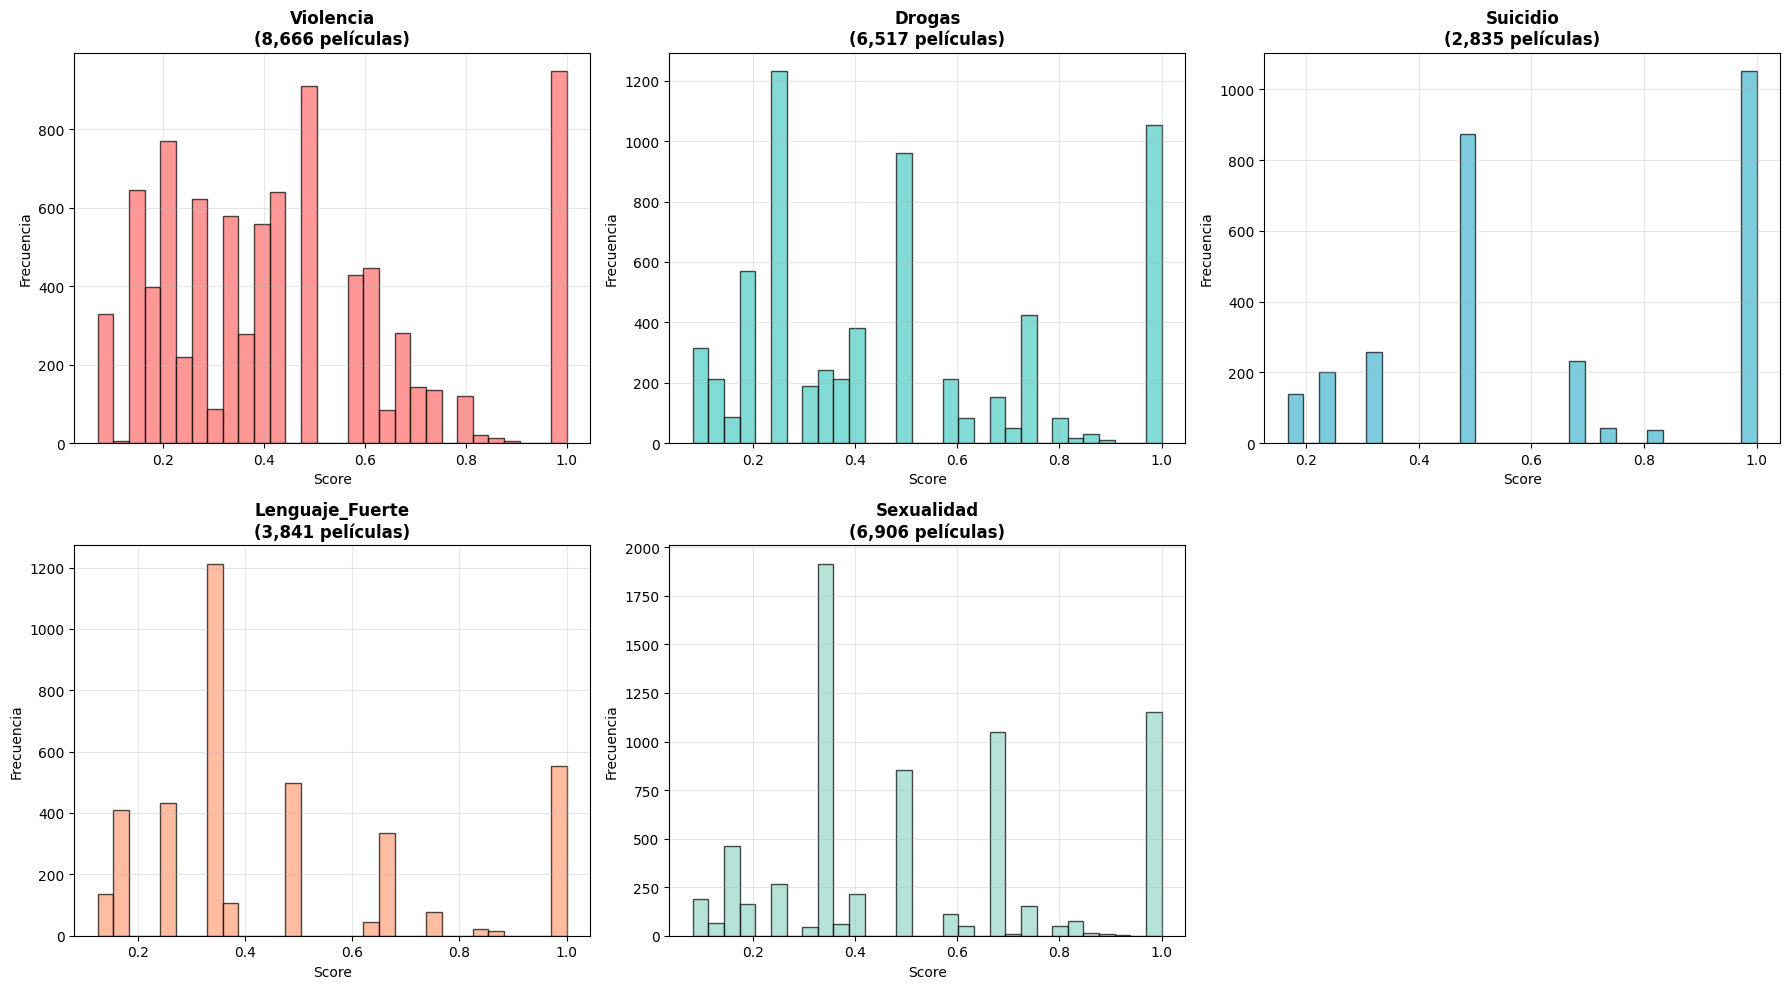

 Visualización de scores completada


In [16]:
# Visualizar distribución de scores
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for i, col in enumerate(score_cols):
    if i < len(axes):
        scores_nonzero = final_df[final_df[col] > 0][col]
        
        axes[i].hist(scores_nonzero, bins=30, color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Frecuencia')
        axes[i].set_title(f'{col.replace("_score", "").title()}\n({len(scores_nonzero):,} películas)', 
                         fontweight='bold')
        axes[i].grid(True, alpha=0.3)

# Ocultar subplot vacío
if len(score_cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

print(" Visualización de scores completada")

## 1.3 Análisis de Links (links.csv)

 Cargando datos de links...
 62,423 links cargados

 Información básica:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB
None

 Primeras filas:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



 Completitud de IDs externos:
  • IMDb ID: 62,423 (100.0%)
  • TMDb ID: 62,316 (99.8%)


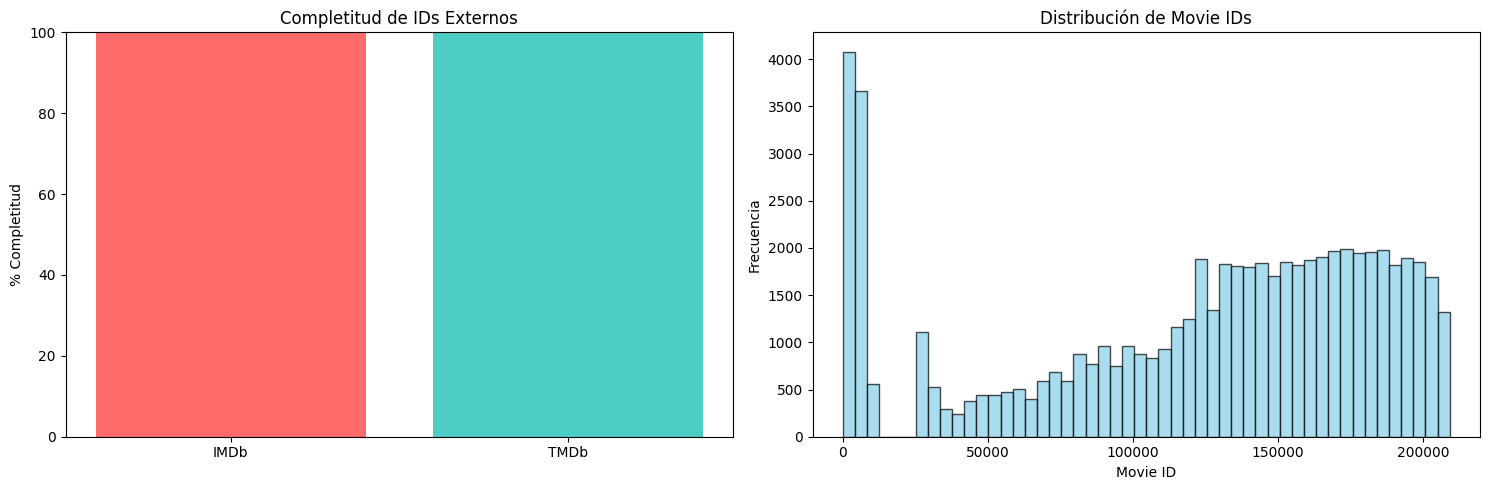

 Análisis de links completado


In [17]:
# Analizar links.csv
print(" Cargando datos de links...")
links_df = pd.read_csv(raw_data_path / "links.csv")

print(f" {len(links_df):,} links cargados")
print(f"\n Información básica:")
print(links_df.info())

print(f"\n Primeras filas:")
display(links_df.head())

# Análisis de completitud
print(f"\n Completitud de IDs externos:")
print(f"  • IMDb ID: {links_df['imdbId'].notna().sum():,} ({links_df['imdbId'].notna().mean()*100:.1f}%)")
print(f"  • TMDb ID: {links_df['tmdbId'].notna().sum():,} ({links_df['tmdbId'].notna().mean()*100:.1f}%)")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Completitud por tipo
completeness = {
    'IMDb': links_df['imdbId'].notna().mean() * 100,
    'TMDb': links_df['tmdbId'].notna().mean() * 100
}

ax1.bar(completeness.keys(), completeness.values(), color=['#FF6B6B', '#4ECDC4'])
ax1.set_ylabel('% Completitud')
ax1.set_title('Completitud de IDs Externos')
ax1.set_ylim(0, 100)

# Distribución de movieIds
ax2.hist(links_df['movieId'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Movie ID')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Movie IDs')

plt.tight_layout()
plt.show()

print(" Análisis de links completado")

In [24]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [25]:
links_df.describe()

,movieId,imdbId,tmdbId
count,62423.000000,6.242300e+04,62316.000000
mean,122220.387646,1.456706e+06,155186.689999
std,63264.744844,2.098007e+06,153362.694700
min,1.000000,1.000000e+00,2.000000
25%,82146.500000,8.168650e+04,36768.750000
50%,138022.000000,3.258050e+05,86750.500000
75%,173222.000000,2.063724e+06,255255.250000
max,209171.000000,1.117094e+07,646282.000000


In [26]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


## 1.4 Análisis de DDD Dictionary (ddd_dict.pkl)

 Diccionario DDD cargado: 137 categorías
 Estructura transformada: 6697656 registros, 137 categorías


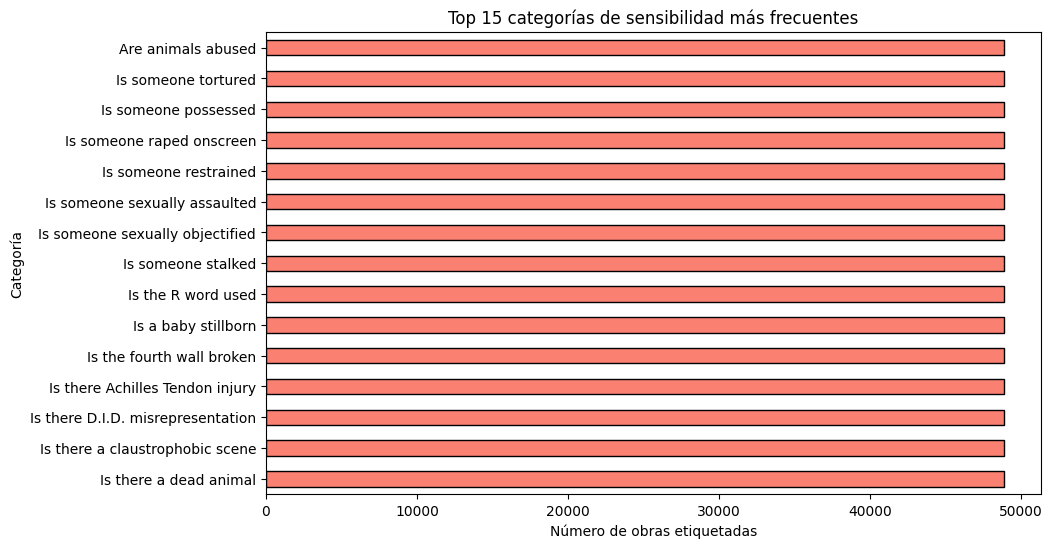

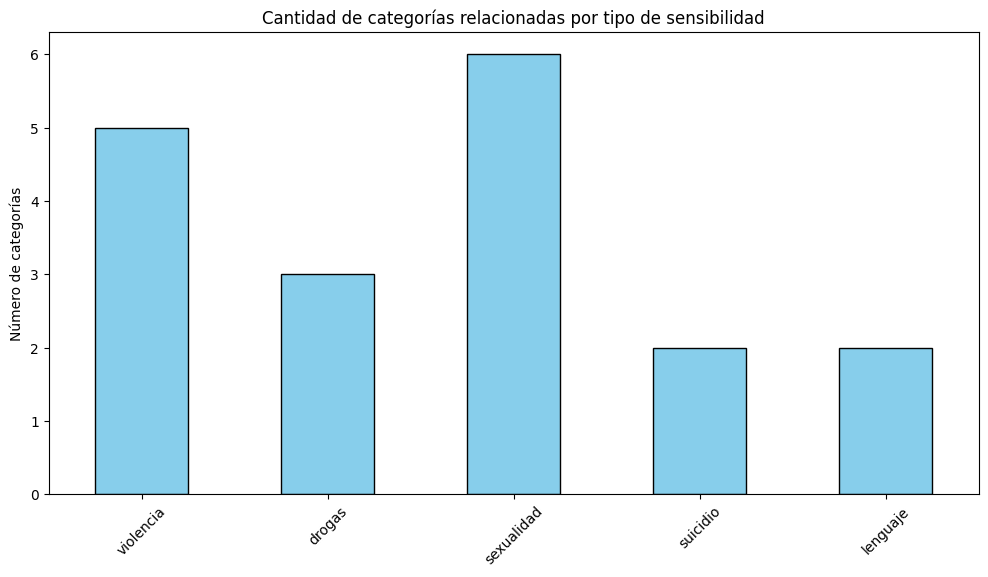

In [18]:
# ============================================
#  Cargar y transformar el DDD Dictionary
# ============================================
import pandas as pd
import pickle

with open(raw_data_path / "ddd_dict.pkl", "rb") as f:
    ddd_dict = pickle.load(f)

print(f" Diccionario DDD cargado: {len(ddd_dict)} categorías")

# Convertir la estructura de diccionario en DataFrame
records = []
for category, works in ddd_dict.items():
    for work_id, value in works.items():
        records.append({
            'category': category,
            'work_id': work_id,
            'value': 1 if value else 0  
        })

ddd_df = pd.DataFrame(records)
print(f" Estructura transformada: {ddd_df.shape[0]} registros, {ddd_df['category'].nunique()} categorías")

# ============================================
#  Análisis exploratorio real
# ============================================

# Frecuencia de categorías (cuántas obras tienen cada etiqueta)
category_freq = ddd_df.groupby('category')['value'].sum().sort_values(ascending=False)

# Top 15 categorías
top15 = category_freq.head(15)

# Gráfico de las 15 categorías más frecuentes
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
top15.plot(kind='barh', color='salmon', edgecolor='black')
plt.title('Top 15 categorías de sensibilidad más frecuentes')
plt.xlabel('Número de obras etiquetadas')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()

# ============================================
#  Agrupación temática (macro categorías)
# ============================================

themes = {
    'violencia': ['kill', 'fight', 'blood', 'murder', 'death'],
    'drogas': ['drug', 'alcohol', 'smoke'],
    'sexualidad': ['sex', 'rape', 'nudity'],
    'suicidio': ['suicide', 'self-harm'],
    'lenguaje': ['swear', 'curse', 'language']
}

# Contar categorías por tema
theme_counts = {theme: ddd_df[ddd_df['category'].str.lower().str.contains('|'.join(keywords))]['category'].nunique()
                for theme, keywords in themes.items()}

theme_df = pd.DataFrame.from_dict(theme_counts, orient='index', columns=['categorías_relacionadas'])

# Visualizar
theme_df.plot(kind='bar', legend=False, color='skyblue', edgecolor='black')
plt.title('Cantidad de categorías relacionadas por tipo de sensibilidad')
plt.ylabel('Número de categorías')
plt.xticks(rotation=45)
plt.show()


In [19]:
import re
import pandas as pd
import pickle

# 1) Cargar diccionario
with open(raw_data_path / "ddd_dict.pkl", "rb") as f:
    ddd_dict = pickle.load(f)

# 2) Sólo los nombres de categoría (Index)
categories = pd.Index(map(str, ddd_dict.keys()))

# 3) Temas y palabras clave
themes = {
    'violencia':  ['kill', 'fight', 'blood', 'murder', 'death'],
    'drogas':     ['drug', 'alcohol', 'smoke'],
    'sexualidad': ['sex', 'rape', 'nudity'],
    'suicidio':   ['suicide', 'self-harm'],
    'lenguaje':   ['swear', 'curse', 'language']
}

def count_theme(cats_idx: pd.Index, keywords: list[str]) -> int:
    # patrón regex, insensible a mayúsculas (case=False)
    pattern = '|'.join(re.escape(k) for k in keywords)
    mask = cats_idx.str.contains(pattern, case=False, regex=True, na=False)
    return int(mask.sum())  # sumamos la máscara booleana

# 4) Conteo de categorías por tema (sin explotar obras)
theme_cat_counts = {t: count_theme(categories, kws) for t, kws in themes.items()}
theme_cat_counts_df = (pd.DataFrame.from_dict(theme_cat_counts, orient='index',
                                              columns=['categorias_relacionadas'])
                       .sort_values('categorias_relacionadas', ascending=False))
print(theme_cat_counts_df)


            categorias_relacionadas
sexualidad                        6
violencia                         5
drogas                            3
suicidio                          2
lenguaje                          2


# 3. Análisis de Correlaciones y Aptitud Familiar

 Analizando correlaciones entre variables...

 Estadísticas de Aptitud Familiar:
count    32604.000000
mean        83.661974
std         26.961642
min          0.000000
25%         70.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: aptitud_familiar, dtype: float64

 Películas con scores: 10,802 de 32,604

 Correlaciones significativas (|r| > 0.3):
  • violencia_score ↔ aptitud_familiar: -0.430
  • drogas_score ↔ aptitud_familiar: -0.429
  • suicidio_score ↔ aptitud_familiar: -0.490
  • lenguaje_fuerte_score ↔ aptitud_familiar: -0.339


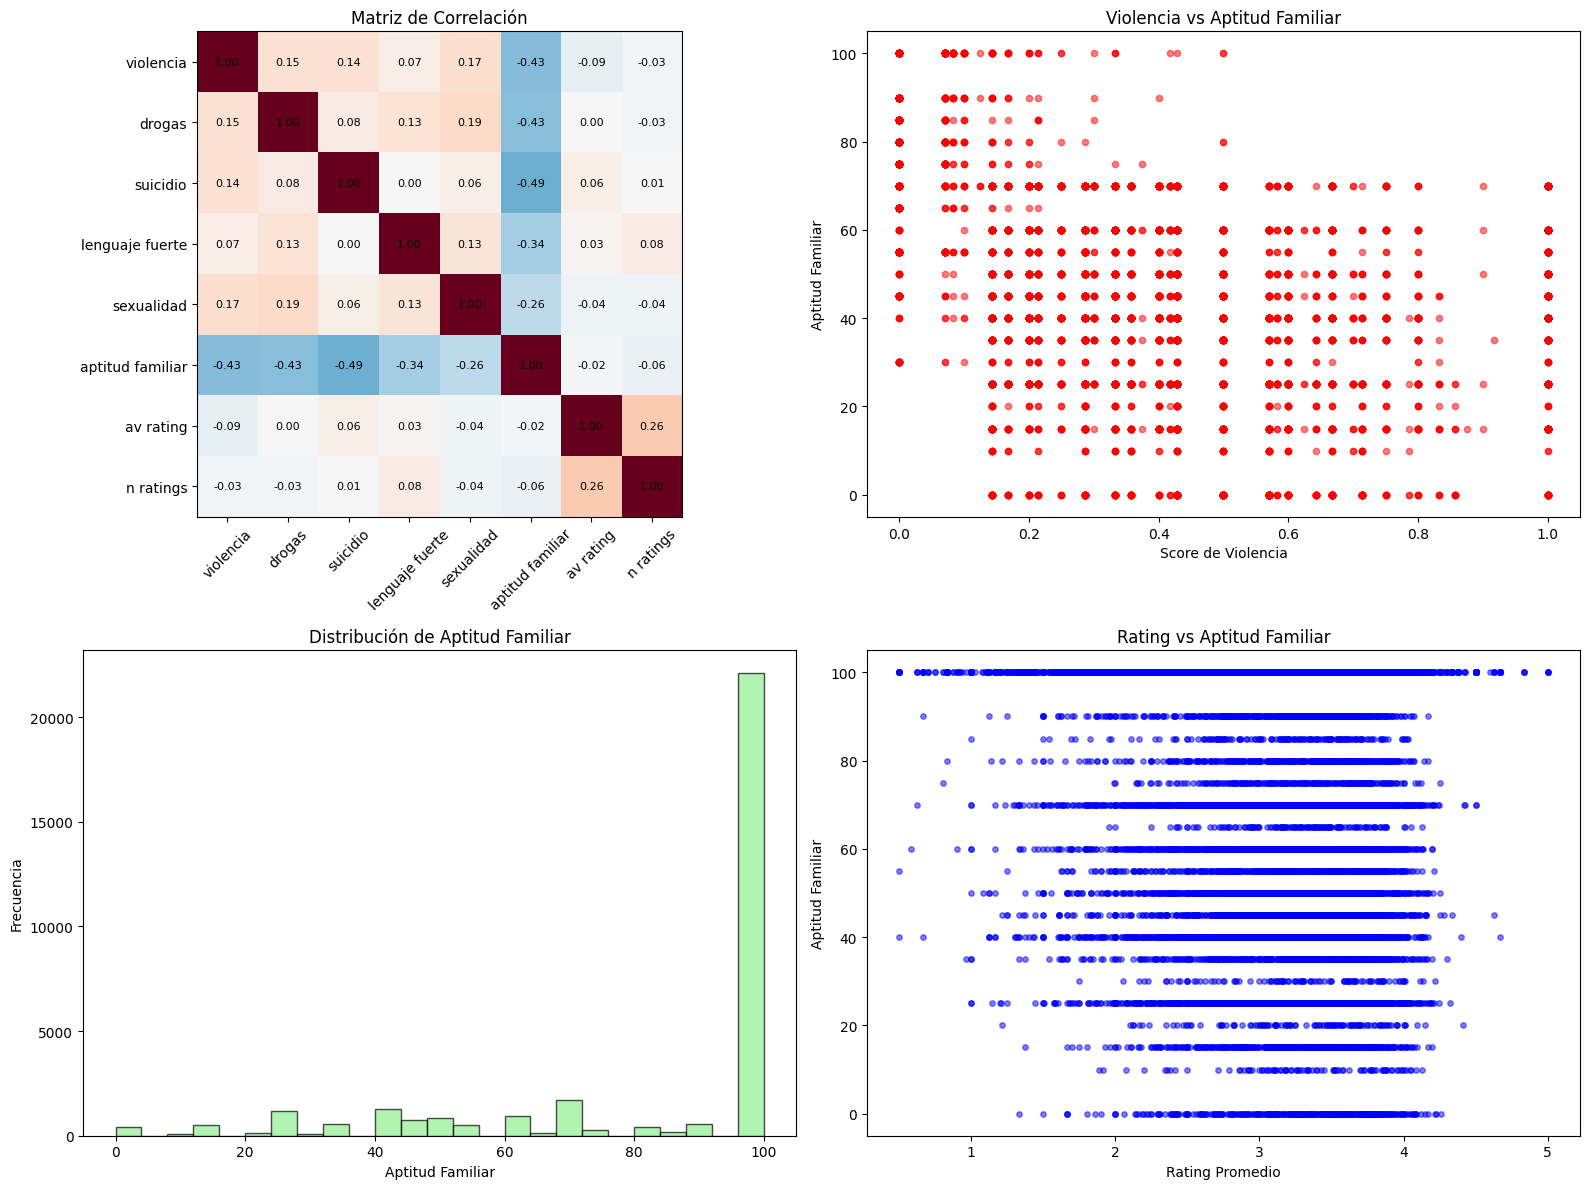

 Análisis de correlaciones completado


In [20]:
# Análisis de correlaciones y aptitud familiar
print(" Analizando correlaciones entre variables...")

# Aptitud familiar
print(f"\n Estadísticas de Aptitud Familiar:")
print(final_df['aptitud_familiar'].describe())

# Correlaciones
movies_with_scores = final_df[final_df[score_cols].sum(axis=1) > 0]
print(f"\n Películas con scores: {len(movies_with_scores):,} de {len(final_df):,}")

corr_cols = score_cols + ['aptitud_familiar', 'av_rating', 'n_ratings']
correlation_matrix = movies_with_scores[corr_cols].corr()

print(f"\n Correlaciones significativas (|r| > 0.3):")
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"  • {corr_cols[i]} ↔ {corr_cols[j]}: {corr_val:.3f}")

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Mapa de calor de correlaciones
import numpy as np
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
im = ax1.imshow(correlation_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_xticks(range(len(corr_cols)))
ax1.set_yticks(range(len(corr_cols)))
ax1.set_xticklabels([col.replace('_score', '').replace('_', ' ') for col in corr_cols], rotation=45)
ax1.set_yticklabels([col.replace('_score', '').replace('_', ' ') for col in corr_cols])
ax1.set_title('Matriz de Correlación')

# Agregar valores
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        text = ax1.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=8)

# 2. Aptitud familiar vs scores principales
ax2.scatter(final_df['violencia_score'], final_df['aptitud_familiar'], alpha=0.5, s=20, color='red')
ax2.set_xlabel('Score de Violencia')
ax2.set_ylabel('Aptitud Familiar')
ax2.set_title('Violencia vs Aptitud Familiar')

# 3. Distribución de aptitud familiar
ax3.hist(final_df['aptitud_familiar'], bins=25, color='lightgreen', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Aptitud Familiar')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Aptitud Familiar')

# 4. Relación ratings vs aptitud
ax4.scatter(final_df['av_rating'], final_df['aptitud_familiar'], alpha=0.5, s=15, color='blue')
ax4.set_xlabel('Rating Promedio')
ax4.set_ylabel('Aptitud Familiar')
ax4.set_title('Rating vs Aptitud Familiar')

plt.tight_layout()
plt.show()

print(" Análisis de correlaciones completado")